In [1]:
import re, sys
sys.path.append('/home/dikshag/pbups_ephys_analysis/pbups_phys/multiregion_RNN/')
from multiregion_RNN_utils import *

import seaborn as sns
sns.set_style("white")
sns.set_theme(context='paper', 
              style='ticks',  
              font='Helvetica', 
              font_scale=1.3,  
              rc={"axes.titlesize": 13})
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['axes.unicode_minus']=False

base_path = get_base_path()
figure_dir = get_figure_dir()

from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter

In [2]:
fitfile = "run_optomul2023_1d_30_30_5"

In [3]:
files = sorted([fn for fn in os.listdir(base_path) if re.findall(fitfile, fn) and not fn.endswith(".npy")])
print(len(files))

10


### Plot showing recovery during first half inactivations

In [ ]:
def format_rnn_activity_forPCA(df_trial, activity, dt, mask = False, zscore = False, center = False):

    stim_on = (df_trial['onset_time']/dt).astype(int) 
    stim_off = ((df_trial['onset_time']+df_trial['stim_duration'])/dt).astype(int) 

    ntrials = len(df_trial)
    num_cells = np.shape(activity)[0]
    X = [] 
    for i in range(num_cells):
        if mask == True:
            fr_align = [activity[i][tr, stim_on[tr]:stim_off[tr]] for tr in range(ntrials)]
        else:
            fr_align = [activity[i][tr, stim_on[tr]:] for tr in range(ntrials)]
            
        fr_align = np.array(list(itertools.zip_longest(*fr_align,fillvalue=np.nan))).T

        # remove mean PSTH
        # with warnings.catch_warnings():
        #     warnings.simplefilter("ignore", category=RuntimeWarning)
        #     fr_align = fr_align - np.nanmean(fr_align, axis = 0)

        X.append(np.ravel(fr_align))

    ntpts_per_trial = [sum(~np.isnan(fr_align[tr])) for tr in range(ntrials)]
    X = np.array(X)
    X = X[:, ~np.all(np.isnan(X), axis = 0)]
    # subtract mean firing rate for each neuron
    if center == True:
        center_mean =  np.mean(X, axis = 1)[:,np.newaxis]
        X = X - center_mean
    # z-score each feature
    if zscore == True:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X = scaler.fit_transform(X.T).T

    if center == True:
        return X, np.array(ntpts_per_trial), center_mean
    else:
        return X, np.array(ntpts_per_trial)
    
    
def compute_PCA(ncomp, X):
    
    pca = PCA()
    pca.fit(X.T)
    pca_var_exp = np.cumsum(pca.explained_variance_ratio_)
    
    pca = PCA(n_components = ncomp)
    pca.fit(X.T)
    
    return pca, pca_var_exp

    
    
def project_onto_PCA_trialwise(pca, X, ntpts):
    
    transform = pca.transform(X.T)
    t0_index = np.hstack(([0], np.cumsum(ntpts)))
    transform_trial = []
    for n in range(pca.n_components):
        temp = [transform[t0:t1, n] for (t0,t1) in zip(t0_index, t0_index[1:])]
        transform_trial.append(np.array(list(itertools.zip_longest(*temp,fillvalue=np.nan))).T)

    return np.array(transform_trial)





In [ ]:
split_by = 'correct'
ncomp = 3

perturb_group = ['left_FOF', 'left_ADS', 'left_proj', 'bi_FOF']
epochs = ['first_half', 'second_half']

# perturb_group = ['left_FOF', 'left_proj']
# epochs = ['first_half']

In [ ]:
file = files[8]

try:
    FOF_ADS.destruct()
except:
    print("Processing fits...")

new_params = {'N_batch': 2000,
              'p_probe': 1.0,
              'rec_noise': 0.,
              'acc_lapse': 0.,
              'probe_duration': 1000}

output_dict = dict()


FOF_ADS, pc_data, model_sim = reinitialize_network(file, new_params)
x_inp, y_inp, m_inp, params = pc_data.get_trial_batch()
output, activity = model_sim.run_trials(x_inp)
output_dict['control'] = output

# parseable format, rearrange FOF neurons to be all together
df_trial, activity, _ = format_data(
    x_inp, 
    y_inp, 
    m_inp, 
    params,output, 
    activity)

split = split_trials(df_trial, split_by)


# align to stimulus onset, get a column for each neuron across trials, and center
Xact, ntpts, center = format_rnn_activity_forPCA(
    df_trial, 
    activity, 
    FOF_ADS.dt,
    center = True)

pca, pca_var_exp = compute_PCA(ncomp, Xact)
pca_projections = dict()
pca_projections['control'] = project_onto_PCA_trialwise(pca, Xact, ntpts)

for this_grp in perturb_group:
    
    pca_projections[this_grp] = dict()
    output_dict[this_grp] = dict()
    
    for eph in epochs:
        
        print(this_grp, eph)
        
        t_connectivity = make_perturbation_inputs_mul(
            FOF_ADS.N_steps,
            perturb_type = eph,
            perturb_group = this_grp,
            gain = 0.1,
            dt = FOF_ADS.dt)
        
        output, activity_pert = model_sim.run_trials(
            x_inp, 
            t_connectivity = t_connectivity)
        
        df_trial_pert, activity_pert, _ = format_data(
            x_inp, 
            y_inp, 
            m_inp, 
            params, 
            output, 
            activity_pert)
        
        Xact_pert, ntpts_pert = format_rnn_activity_forPCA(
            df_trial_pert, 
            activity_pert,
            FOF_ADS.dt,
            center = False)
        
        Xact_pert = Xact_pert - center
        
        
        pca_projections[this_grp][eph] = project_onto_PCA_trialwise(
            pca, 
            Xact_pert, 
            ntpts)
        
        output_dict[this_grp][eph] = output
 
 

### supplementary figure

In [ ]:
# view0 = 20 # for file 3
# view1 = 80 # for file 3

view0 = 20 # for file 8
view1 = 30 # for file 8

eph = 'second_half'

fig = plt.figure(figsize = (5,10))
ax0 = plt.subplot(2,1,1, projection = '3d')
plot_mean_pca_proj_3d(split, pca_projections['control'], ax0, ['Blues','Greens'])
plot_mean_pca_proj_3d(split, pca_projections['left_ADS'][eph], ax0, ['Blues','Greens'], backcol = 'red')

ax0.view_init(view0, view1)
# ax0.set_title('uni FOF (L) inactivation in 2$^{nd}$ half')
ax0.set_title('uni ADS (L) inactivation in 2$^{nd}$ half')

ax0.legend(ncol = 4, loc='upper right', bbox_to_anchor=(1.5, 1.5));

ax1 = plt.subplot(2,1,2, projection = '3d')
plot_mean_pca_proj_3d(split, pca_projections['control'], ax1, ['Blues','Greens'])
plot_mean_pca_proj_3d(split, pca_projections['bi_FOF'][eph], ax1, ['Blues','Greens'], backcol = 'red')
ax1.view_init(view0, view1)

ax1.set_xlim(ax0.get_xlim())
ax1.set_ylim(ax0.get_ylim())
ax1.set_zlim(ax0.get_zlim())
# ax1.set_title('uni FOF  (L) ADS inactivation in 2$^{nd}$ half')
ax1.set_title('bi FOF inactivation in 2$^{nd}$ half')

savethisfig(figure_dir, 'PCAtraj_uniFOF_uniproj_supp_2_' + eph)

### main figure

In [ ]:
# view0 = 20 # for file 3
# view1 = 80 # for file 3

view0 = 20 # for file 8
view1 = 30 # for file 8

fig = plt.figure(figsize = (5,10))
ax0 = plt.subplot(2,1,1, projection = '3d')
plot_mean_pca_proj_3d(split, pca_projections['control'], ax0, ['Blues','Greens'])
plot_mean_pca_proj_3d(split, pca_projections['left_FOF']['first_half'], ax0, ['Blues','Greens'], backcol = 'red')

ax0.view_init(view0, view1)
ax0.set_title('uni (L) FOF inactivation in 1$^{st}$ half')
ax0.legend(ncol = 4, loc='upper right', bbox_to_anchor=(1.5, 1.5));

ax1 = plt.subplot(2,1,2, projection = '3d')
plot_mean_pca_proj_3d(split, pca_projections['control'], ax1, ['Blues','Greens'])
plot_mean_pca_proj_3d(split, pca_projections['left_proj']['first_half'], ax1, ['Blues','Greens'], backcol = 'red')
ax1.view_init(view0, view1)

ax0.set_xlim(ax1.get_xlim())
ax0.set_ylim(ax1.get_ylim())
ax0.set_zlim(ax1.get_zlim())
ax1.set_title('uni FOF  (L) ADS inactivation in 1$^{st}$ half')

savethisfig(figure_dir, 'PCAtraj_uniFOF_uniproj')

### plotting the projection on the output axis

In [ ]:
dt = FOF_ADS.dt
t0 = int(500/dt)
t = np.arange(t0, int(1700/dt))*dt/1000 - 0.5

colors = ['b','g']
cols = {'first_half': [i/255 for i in [250,207,119]],
        'second_half': [i/255 for i in [136,163,113]]}

for var in ['left_FOF', 'left_proj']:
    plt.figure(figsize = (4,1.5))

    output = np.squeeze(output_dict['control'])
 
    for k in list(split):
        if k == 0:
            label = 'Leftward trials'
        else:
            label = 'Rightward trials'
        mean_activity = np.mean(output[split[k],:], axis = 0)
        # plt.plot(t, gaussian_filter(mean_activity[t0:],5), lw = 3, color = 'grey', zorder = 0)
        # plt.scatter(t, gaussian_filter(mean_activity[t0:],5), s = 2, color = colors[k])
        plt.plot(t, gaussian_filter(mean_activity[t0:],5), lw = 2, color = colors[k], zorder = 0, label = label)

    output = np.squeeze(output_dict[var]['first_half'])
    for k in list(split):
        mean_activity = np.mean(output[split[k],:], axis = 0)
        # plt.plot(t, gaussian_filter(mean_activity[t0:],5), lw = 3, color = 'red', zorder = 0)
        # plt.scatter(t, gaussian_filter(mean_activity[t0:],5), s = 2, color = colors[k])
        plt.plot(t, gaussian_filter(mean_activity[t0:],5), lw = 2, color = colors[k], linestyle = '--', zorder = 0)

    for i in ([1, 0, -1]):
        plt.axhline(i, color = 'k', linestyle = ':')
    
    plt.xlabel('Time from clicks on [s]')
    plt.ylabel('Network output')
    plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor = (-0.2, 1.5), ncol = 2)
    
    plt.axvline(0, color = 'k', linestyle = ':')
    plt.axvline(0.5, color = 'k', linestyle = ':')
    plt.axvline(1.0, color = 'k', linestyle = ':')
    plt.text(0.1,1.4,'1$^{st}$ half', backgroundcolor=cols['first_half'])
    plt.text(0.6,1.4,'2$^{nd}$ half', backgroundcolor='w')
    plt.ylim([-1.5, 1.5])
    sns.despine()
    savethisfig(figure_dir, 'output_trajectories_' + var)
    

# What is necessary for recovery in the first half

To test this we will turn off these possible inputs in 2nd half post inactivation
1. inputs from the relay
2. auditory stimulus
3. inputs from the other hemisphere

In [ ]:
query_filename = fitfile + "_uniFOF_recovery_whichinputs_"
ipsi_bias_file = sorted([fn for fn in os.listdir(base_path) if re.findall(query_filename, fn) and fn.endswith(".npy")])
ipsi_bias = np.load(base_path + ipsi_bias_file[0], allow_pickle = True).item()

num_pts = len(ipsi_bias['uni_FOF'])
variables = ['other_FOF', 
             'stim_FOF', 
             'relay_FOF', 
             'other_n_relay_FOF',
             'stim_n_other_FOF',
             'stim_n_relay_FOF']

ticklabels = ['contraFOF', 'stimulus', 'relay', 'contraFOF + relay', 'stimulus + contraFOF', 'stimulus + relay']
summary = np.empty((len(variables), num_pts))
for k, this_var in enumerate(variables):
    summary[k,:] = [x -y for x, y in zip(ipsi_bias[this_var], ipsi_bias['uni_FOF'])]
    
cols = sns.color_palette("flare", 8)
palette = iter(cols)

plt.figure(figsize = (3,4))
for k, (var, offset) in enumerate(zip(variables, [i* 0.5 for i in range(len(variables))])):
    color = next(palette)
    plt.scatter(offset * np.ones(num_pts) + np.random.rand(num_pts)*0.1,
                summary[k,:],
                color = color,
                alpha = 0.2)
    plt.errorbar(offset + 0.05,
                 np.mean(summary[k,:]),
                 yerr = np.std(summary[k,:]),
                 fmt = 'o',
                 color = 'k')
    plt.scatter(offset + 0.05, 
                np.mean(summary[k,:]),
                60,
                color = color,
                edgecolor = 'k',
                zorder = 100)
# plt.ylim([-0.1, 0.25])
plt.axhline(0, color = 'k', linestyle = '--', zorder = 0)
plt.xticks([i* 0.5 + 0.1 for i in range(len(variables))], 
           labels = ticklabels,#['Other FOF', 'SC relay', 'Stimulus'], 
           rotation = 45,
           fontsize = 12)
plt.ylabel('Ipsilateral bias \n compared to uniFOF 1$^{st}$ half inactivations')
plt.xlabel('FOF input silenced during \n 2$^{nd}$ stimulus half')
for t, tick in enumerate(plt.gca().get_xticklabels()):
    tick.set_bbox(dict(facecolor=cols[t], edgecolor=None))

sns.despine()

savethisfig(figure_dir, 'uniFOF_firsthalf_recovery')


In [ ]:
import scikit_posthocs as sp
import scipy.stats as ss

# PRINTING SOME SUMMARY OF THE DATA TO A FILE
output_file = open(figure_dir + "FOFrecoveryinputs_summary.txt",'w')

print("Summary statistics of which inputs are important (done with scikit-posthocs):", file = output_file)

data = [np.array(summary[i,:]) for i in range(len(variables))]
H, p = ss.kruskal(*data)
print("Krukal Wallis (omnibus test) p-value: {}".format(p), file = output_file)
      
print("P-values of posthoc Wilcoxon test with holm correction for multiple comparisions", file = output_file)
p = sp.posthoc_wilcoxon(data, p_adjust ="holm")    
print(p, file = output_file)
print("variables: {}".format(ticklabels), file = output_file)


In [ ]:
p = np.array(p)

from matplotlib.colorbar import ColorbarBase, Colorbar
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors

cmap = ListedColormap(["#FBF0B2", 'white', ])
fig, ax = plt.subplots()
bounds = [0, 0.05, 1.0]
norm = BoundaryNorm(bounds, cmap.N, clip=True)
cax = ax.matshow(p, cmap=cmap, norm = norm)


# Annotate each square with the corresponding value
for i in range(p.shape[0]):
    for j in range(p.shape[1]):
        ax.text(j, i, f'{p[i, j]:.2f}', ha='center', va='center', color='black')

ax.set_xticks(np.arange(len(ticklabels)))
ax.set_yticks(np.arange(len(ticklabels)))
ax.set_xticklabels(ticklabels, rotation = 30, fontsize = 14)
ax.set_yticklabels(ticklabels, fontsize = 14)
ax.yaxis.set_ticks_position('right')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='y', labelright=True, labelleft=False)
ax.tick_params(axis='x', labeltop=False, labelbottom=True)

savethisfig(figure_dir, 'uniFOF_firsthalf_recovery_pvalues')


# What is inviting/preventing recovery

In [5]:
def process_inactivation_summary(summary, perturb_grps, gains = None):
    
    epochs = ['first_half', 'second_half']
    if gains is None:
        gains = list(summary[list(summary)[0]][epochs[0]])
    data = {this_grp:{this_gain:{epoch:[] for epoch in epochs} for this_gain in gains} for this_grp in perturb_grps}
    
    for this_grp in perturb_grps:
        for this_gain in gains:
            for epoch in epochs:
                bias = summary[this_grp][epoch][this_gain]['bias']
                data[this_grp][this_gain][epoch].append(bias)
    return data


query_filename = fitfile + "_whatcauses_recovery_"
summary_file = sorted([fn for fn in os.listdir(base_path) if re.findall(query_filename, fn) and fn.endswith(".npy")])
summary = np.load(base_path + summary_file[0], allow_pickle = True).item()



ipsi_bias = process_inactivation_summary(summary, list(summary))
 

YESS QUEEN: file saved! 
Just look over here: /home/dikshag/pbups_ephys_analysis/saved_results/manuscript_figures/uniFOF_whatcauses_recovery.pdf


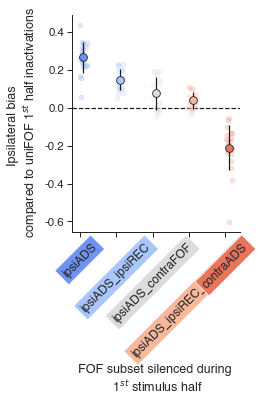

In [49]:
variables = ['ipsiADS', 
             'ipsiADS_ipsiREC', 
             'ipsiADS_contraFOF', 
             'ipsiADS_ipsiREC_contraFOF', 
             'contraADS',
             ]
epoch = 'first_half'


num_pts = np.shape(ipsi_bias['ipsiADS'][0.1][epoch])[1]


summary = np.empty((len(variables), num_pts))
full_inactivation = 'ipsiADS_ipsiREC_contraADS_contraFOF'
for k, this_var in enumerate(variables):
    summary[k,:] = [x -y for (x,y) in zip(np.squeeze(ipsi_bias[this_var][0.1][epoch]),
                                        np.squeeze(ipsi_bias[full_inactivation][0.1][epoch]))]
# for k, this_var in enumerate(variables):
#     summary[k,:] = np.squeeze(ipsi_bias[this_var][0.1][epoch])
                                       
    
cols = sns.color_palette("coolwarm", len(variables))
                                            
palette = iter(cols)

plt.figure(figsize = (3,4))
for k, (var, offset) in enumerate(zip(variables, [i* 0.5 for i in range(len(variables))])):
    color = next(palette)
    plt.scatter(offset * np.ones(num_pts) + np.random.rand(num_pts)*0.1,
                summary[k,:],
                color = color,
                alpha = 0.2)
    plt.errorbar(offset + 0.05,
                 np.mean(summary[k,:]),
                 yerr = np.std(summary[k,:]),
                 fmt = 'o',
                 color = 'k')
    plt.scatter(offset + 0.05, 
                np.mean(summary[k,:]),
                60,
                color = color,
                edgecolor = 'k',
                zorder = 100)
# plt.ylim([-0.1, 0.25])
plt.axhline(0, color = 'k', linestyle = '--', zorder = 0)
plt.xticks([i* 0.5 for i in range(len(variables))], 
           labels = variables, 
           fontsize = 12, 
           rotation = 45)
plt.ylabel('Ipsilateral bias \n compared to uniFOF 1$^{st}$ half inactivations')
plt.xlabel('FOF subset silenced during \n 1$^{st}$ stimulus half')
for t, tick in enumerate(plt.gca().get_xticklabels()):
    tick.set_bbox(dict(facecolor=cols[t], edgecolor=None))

sns.despine()

savethisfig(figure_dir, 'uniFOF_whatcauses_recovery')


In [45]:
import scikit_posthocs as sp
import scipy.stats as ss

ticklabels = variables

# PRINTING SOME SUMMARY OF THE DATA TO A FILE
output_file = open(figure_dir + "FOFwhatcausesrecovery_summary.txt",'w')

print("Summary statistics of which subset inactivations are important (done with scikit-posthocs):", file = output_file)

data = [np.array(summary[i,:]) for i in range(len(variables))]
H, p = ss.kruskal(*data)
print("Krukal Wallis (omnibus test) p-value: {}".format(p), file = output_file)
      
print("P-values of posthoc Wilcoxon test with holm correction for multiple comparisions", file = output_file)
p = sp.posthoc_wilcoxon(data, p_adjust ="holm")    
print(p, file = output_file)
print("variables: {}".format(ticklabels), file = output_file)


YESS QUEEN: file saved! 
Just look over here: /home/dikshag/pbups_ephys_analysis/saved_results/manuscript_figures/uniFOF_firsthalf_whatcauses_recovery.pdf


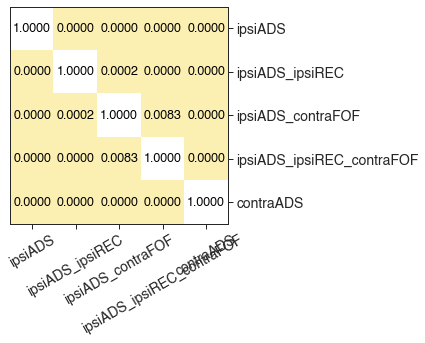

In [48]:
p = np.array(p)

from matplotlib.colorbar import ColorbarBase, Colorbar
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors

cmap = ListedColormap(["#FBF0B2", 'white', ])
fig, ax = plt.subplots()
bounds = [0, 0.05, 1.0]
norm = BoundaryNorm(bounds, cmap.N, clip=True)
cax = ax.matshow(p, cmap=cmap, norm = norm)


# Annotate each square with the corresponding value
for i in range(p.shape[0]):
    for j in range(p.shape[1]):
        ax.text(j, i, f'{p[i, j]:.4f}', ha='center', va='center', color='black')

ax.set_xticks(np.arange(len(ticklabels)))
ax.set_yticks(np.arange(len(ticklabels)))
ax.set_xticklabels(ticklabels, rotation = 30, fontsize = 14)
ax.set_yticklabels(ticklabels, fontsize = 14)
ax.yaxis.set_ticks_position('right')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='y', labelright=True, labelleft=False)
ax.tick_params(axis='x', labeltop=False, labelbottom=True)

savethisfig(figure_dir, 'uniFOF_firsthalf_whatcauses_recovery')


### starting off by plotting the output trajectory under some specific conditions

In [ ]:
from itertools import chain, combinations

def make_perturbation_inputs_mul(N_steps, 
                                 perturb_type, 
                                 source_group, 
                                 target_group, 
                                 dt = 10, 
                                 gain = 0.1):
    
    t_connectivity = np.ones((300,300))
    t_connectivity_perturb = np.ones((300,300))
    
    target_idx = list(chain(*[to_neurons[k] for k in target_group.split('_')]))
    which_neurons = np.ix_(target_idx, from_neurons[source_group])    
    
    if perturb_type == 'whole_trial':
        t0 = 0
        t1 = N_steps
    elif perturb_type == 'first_half':
        t0 = int(500/dt)
        t1 = int(1000/dt)
    elif perturb_type == 'second_half':
        t0 = int(1000/dt)
        t1 = int(1500/dt)
    else:
        print('UNDEFINEED INACTIVATION TYOPE')
        return
    
    t_connectivity_perturb[which_neurons] = gain    
    t_connectivity= np.repeat(t_connectivity[np.newaxis, :, :], N_steps, axis = 0)
    t_connectivity[t0:t1] = t_connectivity_perturb
    
    return t_connectivity


# which projections/areas to perturb
from_neurons = {'leftFOF' : range(40),
               'rightFOF': range(40,80)}

to_neurons = {'leftADS': range(200, 250),
              'rightADS': range(250, 300),
              'leftREC': range(40),
              'rightREC': range(40,80),
              'rightFOF': [*range(40,80), *range(190,200)],
              'leftFOF': [*range(40), *range(180,190)]}

source = 'leftFOF'
all_targets = ['leftADS', 'rightADS', 'leftREC', 'rightFOF', 'leftREC_rightFOF', 'leftADS_leftREC_rightFOF', 'leftADS_leftREC_rightFOF_rightADS','leftADS_leftREC', 'leftADS_rightFOF']

# what kind of perturbations
perturb_type = ['first_half'] 

# gains at which to inactivate
gains = [0.1]


# set all trials to be probe trials for these tests
new_params = {'N_batch': 1000, 
              'p_probe': 1., 
              'probe_duration': 1000}

In [ ]:
file = files[8]

try:
    FOF_ADS.destruct()
except:
    print("Processing")

# reinitialize network
FOF_ADS, pc_data, model_sim = reinitialize_network(file, new_params)

# generate trials and run RNN
x_inp, y_inp, m_inp, params = pc_data.get_trial_batch()
output, activity = FOF_ADS.test(x_inp)
df_trial, _, _ = format_data(x_inp, y_inp, m_inp, params, output, activity)
fracR = compute_fracR(df_trial)
accuracy = np.mean(df_trial['choice'] == df_trial['correct'])

output_dict = dict()
output_dict['control'] = output

split = split_trials(df_trial, "correct")


for target in all_targets:
    output_dict[target] = dict()
    for ptype in perturb_type:
        print(target, ptype)
        output_dict[target][ptype] = dict()
        for gain in gains:
            t_connectivity = make_perturbation_inputs_mul(FOF_ADS.N_steps, 
                                              perturb_type = ptype, 
                                              source_group = source, 
                                              target_group = target,
                                              gain = gain,
                                              dt = FOF_ADS.dt)
            output, activity = model_sim.run_trials(x_inp, 
                                                            t_connectivity = t_connectivity)
            
            output_dict[target][ptype] = output
                
            

In [ ]:
dt = FOF_ADS.dt
t0 = int(500/dt)
t = np.arange(t0, int(1700/dt))*dt/1000 - 0.5

colors = ['b','g']
cols = {'first_half': [i/255 for i in [250,207,119]],
        'second_half': [i/255 for i in [136,163,113]]}

for var in all_targets:
    plt.figure(figsize = (4,1.5))
    
    print(var)

    output = np.squeeze(output_dict['control'])
 
    for k in list(split):
        if k == 0:
            label = 'Leftward trials'
        else:
            label = 'Rightward trials'
        mean_activity = np.mean(output[split[k],:], axis = 0)
        plt.plot(t, gaussian_filter(mean_activity[t0:],5), lw = 2, color = colors[k], zorder = 0, label = label)

    output = np.squeeze(output_dict[var]['first_half'])
    for k in list(split):
        mean_activity = np.mean(output[split[k],:], axis = 0)
        plt.plot(t, gaussian_filter(mean_activity[t0:],5), lw = 2, color = colors[k], linestyle = '--', zorder = 0)

    for i in ([1, 0, -1]):
        plt.axhline(i, color = 'grey', linestyle = ':', linewidth = 0.5)
    
    plt.xlabel('Time from clicks on [s]')
    plt.ylabel('Network output')
    # plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor = (-0.2, 1.5), ncol = 2)
    
    plt.axvline(0, color = 'grey', linestyle = ':', linewidth = 0.5)
    plt.axvline(0.5, color = 'grey', linestyle = ':', linewidth = 0.5)
    plt.axvline(1.0, color = 'grey', linestyle = ':', linewidth = 0.5)
    plt.text(0.1,1.4,'1$^{st}$ half', backgroundcolor=cols['first_half'])
    plt.text(0.6,1.4,'2$^{nd}$ half', backgroundcolor='w')
    plt.ylim([-1.5, 1.5])
    sns.despine()
    # plt.show()
    savethisfig(figure_dir, 'fig5_whichinput_output_trajectories_' + var)
    